<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [168]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [169]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

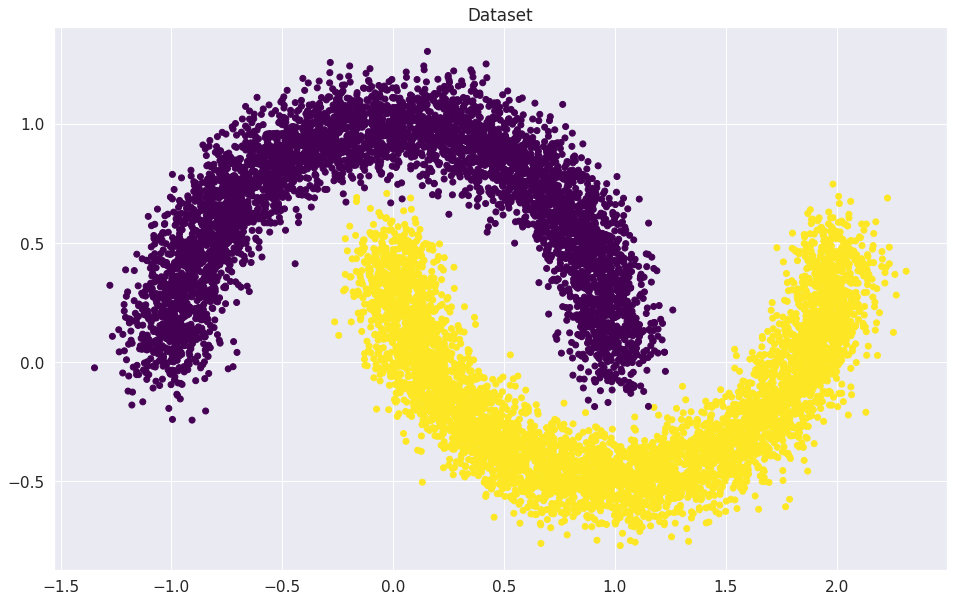

In [170]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [171]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [172]:
X_train_t =  torch.from_numpy(X_train).to(torch.float32)
y_train_t =  torch.from_numpy(y_train).to(torch.float32)
X_val_t =  torch.from_numpy(X_val).to(torch.float32)
y_val_t =  torch.from_numpy(y_val).to(torch.float32)

Создаем `Dataset` и `DataLoader`. 

In [173]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [204]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        x =  x.mm(self.weights.t())
        if self.bias:
            x +=  self.bias_term
        return x

In [205]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [206]:
pytorch_total_params = sum(p.numel() for p in linear_regression.parameters())

pytorch_total_params

3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [207]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False

for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        x = X_batch
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp[:,0],y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  nn.functional.sigmoid(outp[:,0])
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.765625
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.8125
Iteration: 300
Batch accuracy: 0.8984375
Iteration: 400
Batch accuracy: 0.8828125
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.875

Iteration: 696.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** В зависимости от запуска iteration = 500 - 950
(вычисленное значение на данном запуске = 696)

### Визуализируем результаты

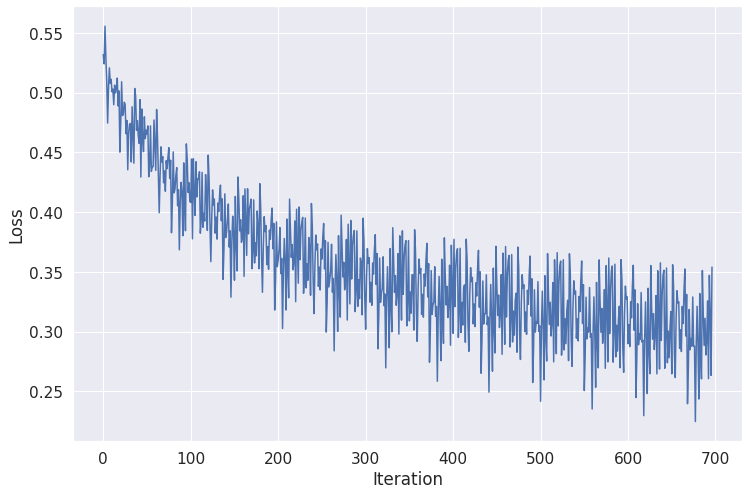

In [208]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

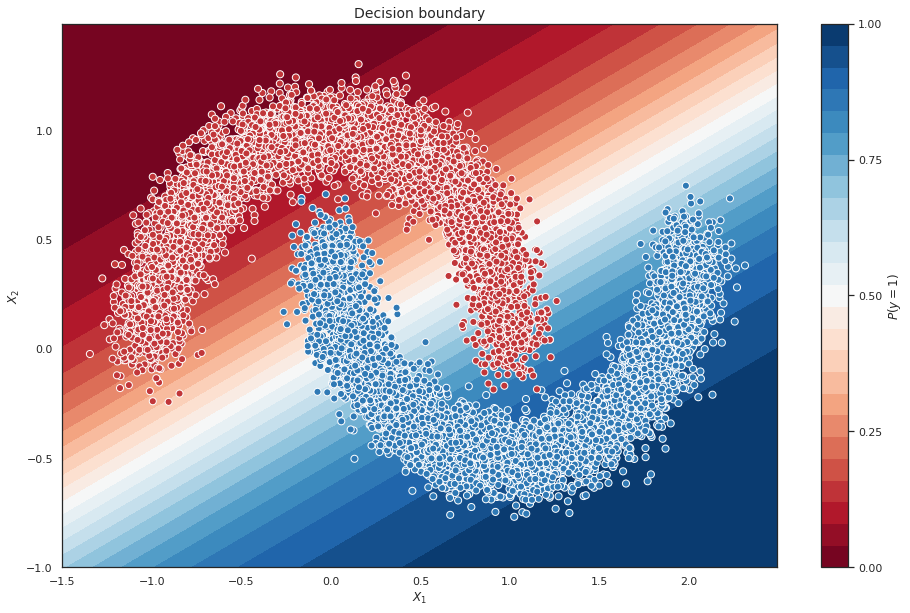

In [209]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [210]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp =  linear_regression(x_batch)
        probabilities =  nn.functional.sigmoid(outp[:,0])
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [211]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_val_t, predict(val_dataloader, linear_regression))

accuracy

0.8624

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** В зависимости от запуска точность = 0.8-0.9
(На данном запуске 0.8624)

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [212]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader = DataLoader(val_dataset, batch_size=128)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [213]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [214]:
activation = nn.ELU()

model = nn.Sequential( 
    nn.Flatten(), 
    nn.Linear(784, 128), 
    activation, 
    nn.Linear(128, 128), 
    activation, 
    nn.Linear(128, 128), 
    activation, 
    nn.Linear(128, 10), 
)


In [215]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [216]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [217]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = len(preds[preds == y_batch])
            # correct =  (preds @ y_batch > 0.5).size
            all =  len(preds)
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.87765
Loader: valid. Accuracy: 0.9247
Epoch: 2
Loader: train. Accuracy: 0.9431
Loader: valid. Accuracy: 0.9521
Epoch: 3
Loader: train. Accuracy: 0.9597
Loader: valid. Accuracy: 0.9623
Epoch: 4
Loader: train. Accuracy: 0.9674333333333334
Loader: valid. Accuracy: 0.9649
Epoch: 5
Loader: train. Accuracy: 0.97365
Loader: valid. Accuracy: 0.9612
Epoch: 6
Loader: train. Accuracy: 0.9782166666666666
Loader: valid. Accuracy: 0.9666
Epoch: 7
Loader: train. Accuracy: 0.9809666666666667
Loader: valid. Accuracy: 0.9678
Epoch: 8
Loader: train. Accuracy: 0.9819166666666667
Loader: valid. Accuracy: 0.9678
Epoch: 9
Loader: train. Accuracy: 0.9807833333333333
Loader: valid. Accuracy: 0.9625
Epoch: 10
Loader: train. Accuracy: 0.9849
Loader: valid. Accuracy: 0.9656


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [218]:
elu_accuracy = accuracy["valid"]

In [219]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
  
    model = nn.Sequential( 
        nn.Flatten(), 
        nn.Linear(784, 128), 
        activation, 
        nn.Linear(128, 128), 
        activation, 
        nn.Linear(128, 128), 
        activation, 
        nn.Linear(128, 10), 
    )
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                      outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = len(preds[preds == y_batch])
                # correct =  (preds @ y_batch > 0.5).size
                all =  len(preds)
                epoch_correct += correct
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy['valid']

In [220]:
plain_accuracy = test_activation_function(Identical())

Epoch: 1
Loader: train. Accuracy: 0.8576333333333334
Loader: valid. Accuracy: 0.8767
Epoch: 2
Loader: train. Accuracy: 0.8897666666666667
Loader: valid. Accuracy: 0.8945
Epoch: 3
Loader: train. Accuracy: 0.8951666666666667
Loader: valid. Accuracy: 0.8956
Epoch: 4
Loader: train. Accuracy: 0.8981166666666667
Loader: valid. Accuracy: 0.8973
Epoch: 5
Loader: train. Accuracy: 0.9007333333333334
Loader: valid. Accuracy: 0.8974
Epoch: 6
Loader: train. Accuracy: 0.9025833333333333
Loader: valid. Accuracy: 0.8973
Epoch: 7
Loader: train. Accuracy: 0.90365
Loader: valid. Accuracy: 0.8974
Epoch: 8
Loader: train. Accuracy: 0.9047666666666667
Loader: valid. Accuracy: 0.898
Epoch: 9
Loader: train. Accuracy: 0.9061833333333333
Loader: valid. Accuracy: 0.8983
Epoch: 10
Loader: train. Accuracy: 0.9079333333333334
Loader: valid. Accuracy: 0.899


In [221]:
relu_accuracy = test_activation_function(nn.ReLU())

Epoch: 1
Loader: train. Accuracy: 0.8546
Loader: valid. Accuracy: 0.9221
Epoch: 2
Loader: train. Accuracy: 0.9335
Loader: valid. Accuracy: 0.9392
Epoch: 3
Loader: train. Accuracy: 0.9524
Loader: valid. Accuracy: 0.9543
Epoch: 4
Loader: train. Accuracy: 0.9615166666666667
Loader: valid. Accuracy: 0.9595
Epoch: 5
Loader: train. Accuracy: 0.96665
Loader: valid. Accuracy: 0.9647
Epoch: 6
Loader: train. Accuracy: 0.9712166666666666
Loader: valid. Accuracy: 0.9618
Epoch: 7
Loader: train. Accuracy: 0.9759833333333333
Loader: valid. Accuracy: 0.9676
Epoch: 8
Loader: train. Accuracy: 0.9787666666666667
Loader: valid. Accuracy: 0.971
Epoch: 9
Loader: train. Accuracy: 0.97915
Loader: valid. Accuracy: 0.9721
Epoch: 10
Loader: train. Accuracy: 0.98175
Loader: valid. Accuracy: 0.9723


In [222]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())

Epoch: 1
Loader: train. Accuracy: 0.8610166666666667
Loader: valid. Accuracy: 0.9266
Epoch: 2
Loader: train. Accuracy: 0.9403
Loader: valid. Accuracy: 0.9519
Epoch: 3
Loader: train. Accuracy: 0.9556
Loader: valid. Accuracy: 0.9602
Epoch: 4
Loader: train. Accuracy: 0.9647833333333333
Loader: valid. Accuracy: 0.9587
Epoch: 5
Loader: train. Accuracy: 0.9693666666666667
Loader: valid. Accuracy: 0.9672
Epoch: 6
Loader: train. Accuracy: 0.9734
Loader: valid. Accuracy: 0.9698
Epoch: 7
Loader: train. Accuracy: 0.9773
Loader: valid. Accuracy: 0.9708
Epoch: 8
Loader: train. Accuracy: 0.9790833333333333
Loader: valid. Accuracy: 0.972
Epoch: 9
Loader: train. Accuracy: 0.97985
Loader: valid. Accuracy: 0.966
Epoch: 10
Loader: train. Accuracy: 0.9823333333333333
Loader: valid. Accuracy: 0.9633


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

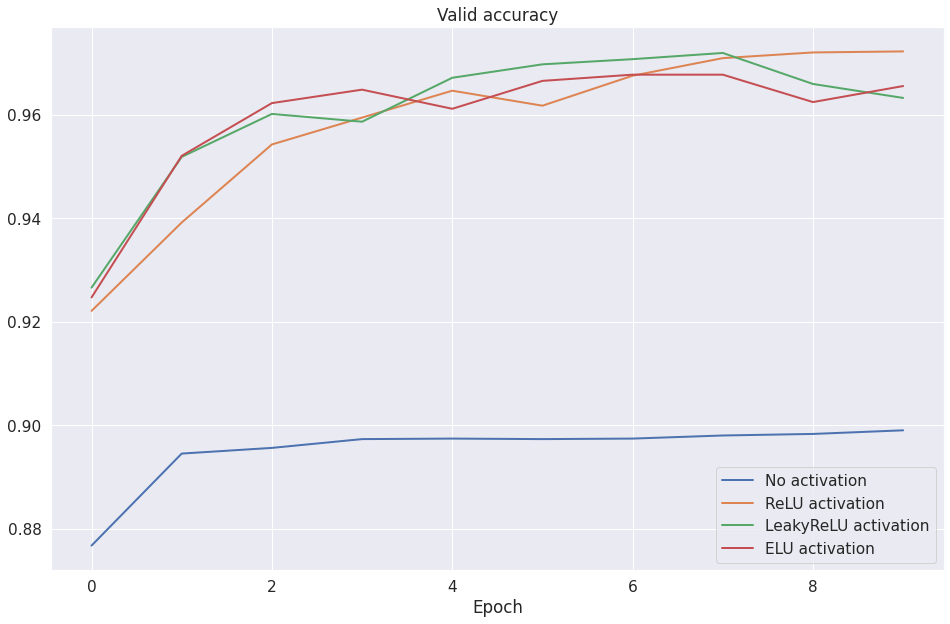

In [223]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

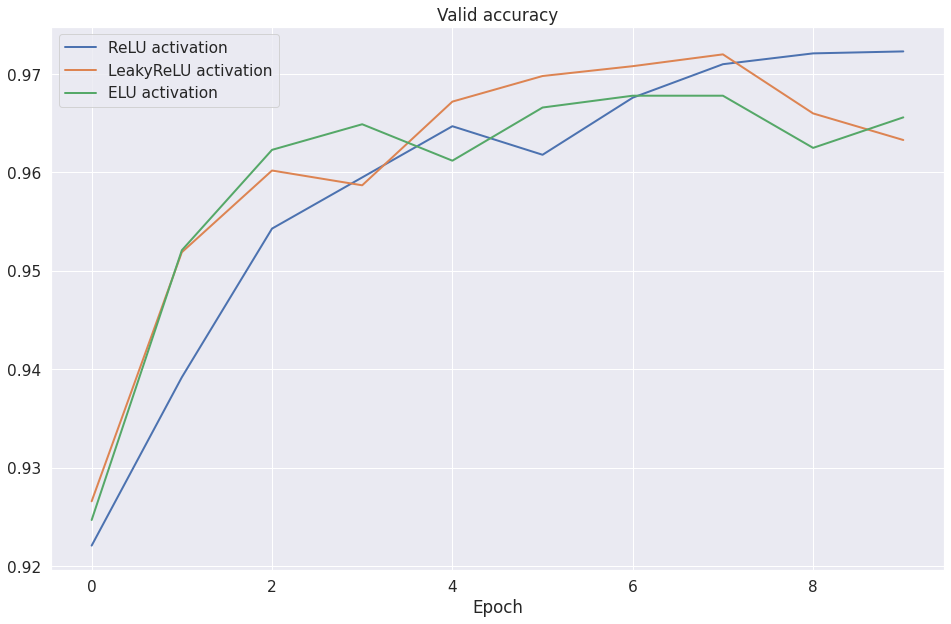

In [224]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** В зависимости от запуска лучшее качество показывает ELU и RELU
(в данном запуске RELU)

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [225]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-10-27 13:59:44--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-10-27 13:59:45--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   123KB/s    in 0.4s    

2022-10-27 13:59:46 (123 KB/s) - ‘sample_photo.jpg’ saved [49337/4

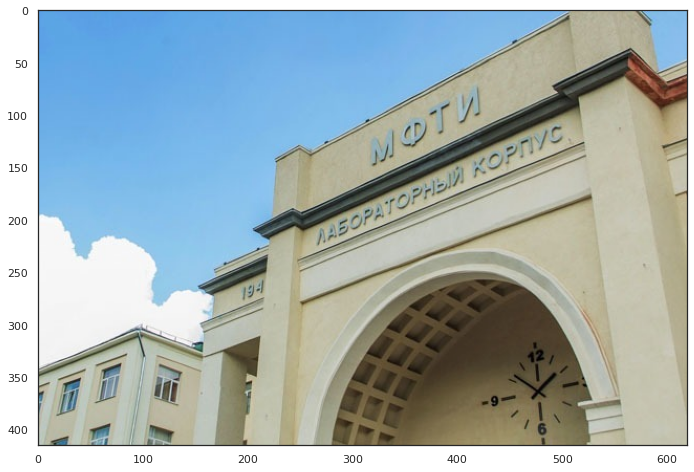

In [226]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [227]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
[0, -2, 0],
[0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

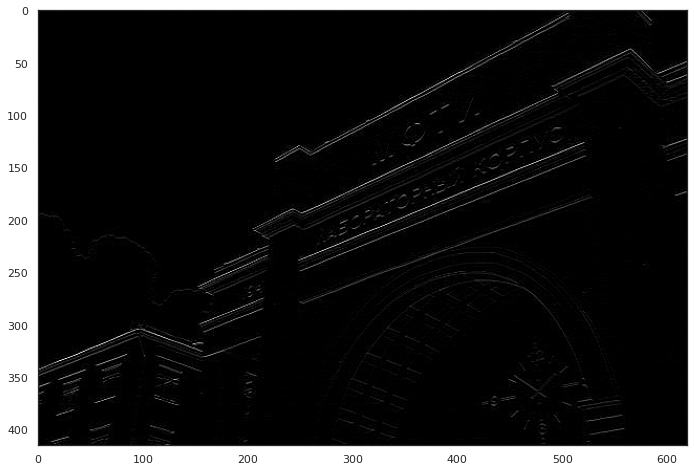

In [228]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие Е)

2) Увеличение резкости Д)

3) Тождественное преобразование А)

4) Выделение вертикальных границ В)

5) Выделение горизонтальных границ Б)

6) Выделение границ Г)

**Ответ:** Ядра преобразуют спектр изображения, служат своеобразными фильтрами

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [229]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d((2,2))
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d((2,2))
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        self.relu = nn.functional.relu

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        # x = nn.Flatten(x)
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [230]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [231]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = len(preds[preds == y_batch])
            # correct =  (preds @ y_batch > 0.5).size
            all =  len(preds)
            epoch_correct += correct
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8810333333333333
Loader: valid. Accuracy: 0.9664
Epoch: 2
Loader: train. Accuracy: 0.9669333333333333
Loader: valid. Accuracy: 0.9747
Epoch: 3
Loader: train. Accuracy: 0.9768
Loader: valid. Accuracy: 0.9795
Epoch: 4
Loader: train. Accuracy: 0.9818666666666667
Loader: valid. Accuracy: 0.9812
Epoch: 5
Loader: train. Accuracy: 0.9847666666666667
Loader: valid. Accuracy: 0.9815
Epoch: 6
Loader: train. Accuracy: 0.98735
Loader: valid. Accuracy: 0.9824
Epoch: 7
Loader: train. Accuracy: 0.9888833333333333
Loader: valid. Accuracy: 0.9843
Epoch: 8
Loader: train. Accuracy: 0.99045
Loader: valid. Accuracy: 0.9853
Epoch: 9
Loader: train. Accuracy: 0.99185
Loader: valid. Accuracy: 0.9842
Epoch: 10
Loader: train. Accuracy: 0.9926166666666667
Loader: valid. Accuracy: 0.9844


In [232]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

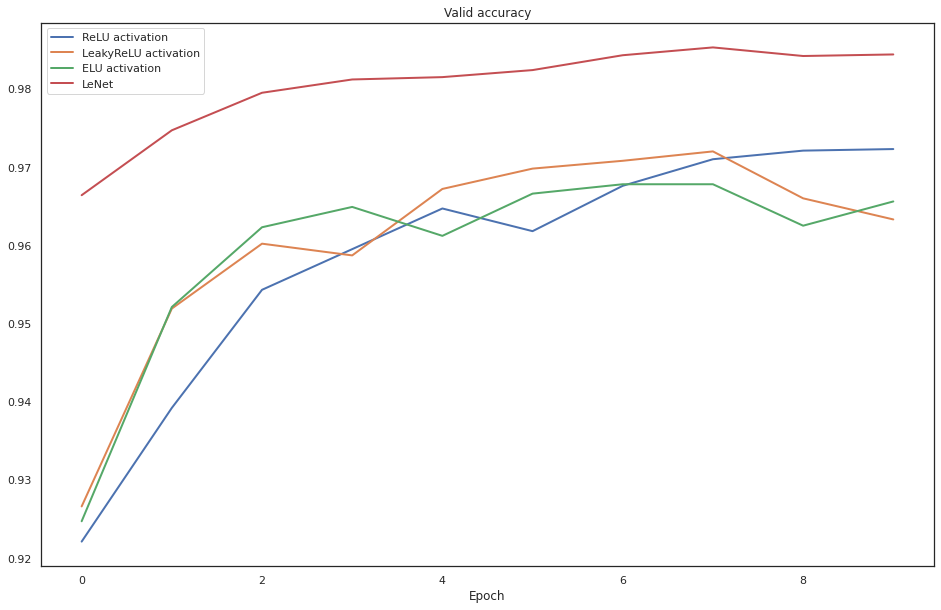

In [233]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [234]:
lenet_accuracy

[0.9664,
 0.9747,
 0.9795,
 0.9812,
 0.9815,
 0.9824,
 0.9843,
 0.9853,
 0.9842,
 0.9844]

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** Финальное значение точности = 0.98-0.99 (В данном запуске: 0.98)